# Introduction

Sentiment Analysis, a subset of Natural Language Processing (NLP) help users to make binary predictions based on the emotions expressed in textual data. In the real world, NLP enable companies to analyse large datasets, extract consumer insights and make data driven decisions that could potentially improve user experiences. This notebook would use NLP, specifically the nnlm model to make binary predictions on stock comments. Firstly, we would need to import relevant libraries for the project:

# Import relevant libraries

In [2]:
import pandas as pd
pd.set_option("display.max_colwidth", 200)

In [3]:
import nltk
import re                                  
import string                             
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\htaoh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

# Text Preprocessing
Next, we would need to preprocess the raw text from the dataset to improve the model's accuracy. This process involves lower casing, removing URLs, special letters, punctuation and stopwords. It is followed by lemmatization. Lemmatization reduces a text to its root form without loosing its contextual meaning.

In [5]:
df = pd.read_csv("stock_data.csv")
df

,Text,Sentiment
0,"Kickers on my watchlist XIDE TIT SOQ PNK CPW BPZ AJ trade method 1 or method 2, see prev posts",1
1,user: AAP MOVIE. 55% return for the FEA/GEED indicator just 15 trades for the year. AWESOME.,1
2,user I'd be afraid to short AMZN - they are looking like a near-monopoly in eBooks and infrastructure-as-a-service,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
...,...,...
5786,"Industry body CII said #discoms are likely to suffer a net revenue loss of around Rs 30,000 crore\n\nhttps://t.co/8c6YJYJajL",-1
5787,"#Gold prices slip below Rs 46,000 as #investors book profits amid #coronavirus-led #recession fears https://t.co/fSylAJrUqv",-1
5788,Workers at Bajaj Auto have agreed to a 10% wage cut for the period between April 15 and till the lockdown is lifted. https://t.co/RgvrKPliNd,1
5789,"#Sharemarket LIVE: Sensex off day’s high, up 600 points, #Nifty tests 9,200, #TCS, private bank stocks lead\nhttps://t.co/3xgtLroKUI",1


To improve the accuracy of the model, neagtive sentiment indicated as '-1' would be changed to 0 while positive sentiment indicated as '1' would remain as 1

In [6]:
df['new_sentiment']=df['Sentiment'].apply(lambda x: 0 if x==-1 else 1)
new_df = df.drop(['Sentiment'],axis = 1)
new_df

,Text,new_sentiment
0,"Kickers on my watchlist XIDE TIT SOQ PNK CPW BPZ AJ trade method 1 or method 2, see prev posts",1
1,user: AAP MOVIE. 55% return for the FEA/GEED indicator just 15 trades for the year. AWESOME.,1
2,user I'd be afraid to short AMZN - they are looking like a near-monopoly in eBooks and infrastructure-as-a-service,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
...,...,...
5786,"Industry body CII said #discoms are likely to suffer a net revenue loss of around Rs 30,000 crore\n\nhttps://t.co/8c6YJYJajL",0
5787,"#Gold prices slip below Rs 46,000 as #investors book profits amid #coronavirus-led #recession fears https://t.co/fSylAJrUqv",0
5788,Workers at Bajaj Auto have agreed to a 10% wage cut for the period between April 15 and till the lockdown is lifted. https://t.co/RgvrKPliNd,1
5789,"#Sharemarket LIVE: Sensex off day’s high, up 600 points, #Nifty tests 9,200, #TCS, private bank stocks lead\nhttps://t.co/3xgtLroKUI",1


In [7]:
#to lowercase all text
def casefolding(Review):
    Review = Review.lower()
    return Review
new_df['Text'] = new_df['Text'].apply(casefolding)
new_df.head(10)

,Text,new_sentiment
0,"kickers on my watchlist xide tit soq pnk cpw bpz aj trade method 1 or method 2, see prev posts",1
1,user: aap movie. 55% return for the fea/geed indicator just 15 trades for the year. awesome.,1
2,user i'd be afraid to short amzn - they are looking like a near-monopoly in ebooks and infrastructure-as-a-service,1
3,mnta over 12.00,1
4,oi over 21.37,1
5,pgnx over 3.04,1
6,aap - user if so then the current downtrend will break. otherwise just a short-term correction in med-term downtrend.,0
7,monday's relative weakness. nyx win tie tap ice int bmc aon c chk biib,0
8,goog - ower trend line channel test & volume support.,1
9,aap will watch tomorrow for ong entry.,1


In [8]:
#remove special characters and some punctuation
def cleansing(Review):
    Review = Review.strip(" ")
    Review = re.sub(r'[?|$|.|!_:")(-+,]', '', Review)
    Review = re.sub(r'\d+', '', Review)
    Review = re.sub(r"\b[a-zA-Z]\b", "", Review)
    Review = re.sub('\s+',' ', Review)
    return Review
new_df['Text'] = new_df['Text'].apply(lambda x: cleansing(x))

In [9]:
#remove hyperlinks
>>> new_df['Text'] = new_df['Text'].str.split('https').str[0]
>>> new_df

,Text,new_sentiment
0,kickers on my watchlist xide tit soq pnk cpw bpz aj trade method or method see prev posts,1
1,user aap movie % return for the fea/geed indicator just trades for the year awesome,1
2,user ' be afraid to short amzn - they are looking like near-monopoly in ebooks and infrastructure-as--service,1
3,mnta over,1
4,oi over,1
...,...,...
5786,industry body cii said #discoms are likely to suffer net revenue loss of around rs crore,0
5787,#gold prices slip below rs as #investors book profits amid #coronavirus-led #recession fears,0
5788,workers at bajaj auto have agreed to % wage cut for the period between april and till the lockdown is lifted,1
5789,#sharemarket live sensex off day’ high up points #nifty tests #tcs private bank stocks lead,1


In [10]:
#import library that contains punctuation
string.punctuation
#Function to remove punctation
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
#code to remove punctuation from text
new_df['Text']= new_df['Text'].apply(lambda x:remove_punctuation(x))
new_df

,Text,new_sentiment
0,kickers on my watchlist xide tit soq pnk cpw bpz aj trade method or method see prev posts,1
1,user aap movie return for the feageed indicator just trades for the year awesome,1
2,user be afraid to short amzn they are looking like nearmonopoly in ebooks and infrastructureasservice,1
3,mnta over,1
4,oi over,1
...,...,...
5786,industry body cii said discoms are likely to suffer net revenue loss of around rs crore,0
5787,gold prices slip below rs as investors book profits amid coronavirusled recession fears,0
5788,workers at bajaj auto have agreed to wage cut for the period between april and till the lockdown is lifted,1
5789,sharemarket live sensex off day’ high up points nifty tests tcs private bank stocks lead,1


In [11]:
#Function to tokenise text
def tokenization(text):
    tokenizer = TweetTokenizer(preserve_case=False, 
                           strip_handles=True,
                           reduce_len=True)
    tokens = tokenizer.tokenize(text)
    return tokens
#Applying tokenisation to text
new_df['Text']= new_df['Text'].apply(lambda x: tokenization(x))

In [12]:
new_df

,Text,new_sentiment
0,"[kickers, on, my, watchlist, xide, tit, soq, pnk, cpw, bpz, aj, trade, method, or, method, see, prev, posts]",1
1,"[user, aap, movie, return, for, the, feageed, indicator, just, trades, for, the, year, awesome]",1
2,"[user, be, afraid, to, short, amzn, they, are, looking, like, nearmonopoly, in, ebooks, and, infrastructureasservice]",1
3,"[mnta, over]",1
4,"[oi, over]",1
...,...,...
5786,"[industry, body, cii, said, discoms, are, likely, to, suffer, net, revenue, loss, of, around, rs, crore]",0
5787,"[gold, prices, slip, below, rs, as, investors, book, profits, amid, coronavirusled, recession, fears]",0
5788,"[workers, at, bajaj, auto, have, agreed, to, wage, cut, for, the, period, between, april, and, till, the, lockdown, is, lifted]",1
5789,"[sharemarket, live, sensex, off, day, ’, high, up, points, nifty, tests, tcs, private, bank, stocks, lead]",1


In [13]:
#Library of stopwords
stopwords = nltk.corpus.stopwords.words('english')
#defining the function to remove stopwords from tokenized text
def remove_stopwords(text):
    output= [i for i in text if i not in stopwords]
    return output
#applying the function
new_df['Text']=new_df['Text'].apply(lambda x:remove_stopwords(x))

In [14]:
new_df

,Text,new_sentiment
0,"[kickers, watchlist, xide, tit, soq, pnk, cpw, bpz, aj, trade, method, method, see, prev, posts]",1
1,"[user, aap, movie, return, feageed, indicator, trades, year, awesome]",1
2,"[user, afraid, short, amzn, looking, like, nearmonopoly, ebooks, infrastructureasservice]",1
3,[mnta],1
4,[oi],1
...,...,...
5786,"[industry, body, cii, said, discoms, likely, suffer, net, revenue, loss, around, rs, crore]",0
5787,"[gold, prices, slip, rs, investors, book, profits, amid, coronavirusled, recession, fears]",0
5788,"[workers, bajaj, auto, agreed, wage, cut, period, april, till, lockdown, lifted]",1
5789,"[sharemarket, live, sensex, day, ’, high, points, nifty, tests, tcs, private, bank, stocks, lead]",1


In [15]:
#packages to download for lemmatization
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\htaoh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\htaoh\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [16]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
#defining the function for lemmatization
def lemmatizer(text):
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text
#lemmatizing the text
new_df['Text']=new_df['Text'].apply(lambda x:lemmatizer(x))
new_df

,Text,new_sentiment
0,"[kicker, watchlist, xide, tit, soq, pnk, cpw, bpz, aj, trade, method, method, see, prev, post]",1
1,"[user, aap, movie, return, feageed, indicator, trade, year, awesome]",1
2,"[user, afraid, short, amzn, looking, like, nearmonopoly, ebooks, infrastructureasservice]",1
3,[mnta],1
4,[oi],1
...,...,...
5786,"[industry, body, cii, said, discoms, likely, suffer, net, revenue, loss, around, r, crore]",0
5787,"[gold, price, slip, r, investor, book, profit, amid, coronavirusled, recession, fear]",0
5788,"[worker, bajaj, auto, agreed, wage, cut, period, april, till, lockdown, lifted]",1
5789,"[sharemarket, live, sensex, day, ’, high, point, nifty, test, tc, private, bank, stock, lead]",1


In [17]:
new_df['Text']

0       [kicker, watchlist, xide, tit, soq, pnk, cpw, bpz, aj, trade, method, method, see, prev, post]
1                                 [user, aap, movie, return, feageed, indicator, trade, year, awesome]
2            [user, afraid, short, amzn, looking, like, nearmonopoly, ebooks, infrastructureasservice]
3                                                                                               [mnta]
4                                                                                                 [oi]
                                                     ...                                              
5786        [industry, body, cii, said, discoms, likely, suffer, net, revenue, loss, around, r, crore]
5787             [gold, price, slip, r, investor, book, profit, amid, coronavirusled, recession, fear]
5788                   [worker, bajaj, auto, agreed, wage, cut, period, april, till, lockdown, lifted]
5789     [sharemarket, live, sensex, day, ’, high, point, nifty, test, tc

In [18]:
#Remove the tokens and pass the cleaned text into the dataframe as strings
def stemming(Review):
    do = []
    for w in Review:
        do.append(w)
    d_clean=[]
    d_clean=" ".join(do)
    return d_clean
new_df['Text'] = new_df['Text'].apply(stemming)
new_df

,Text,new_sentiment
0,kicker watchlist xide tit soq pnk cpw bpz aj trade method method see prev post,1
1,user aap movie return feageed indicator trade year awesome,1
2,user afraid short amzn looking like nearmonopoly ebooks infrastructureasservice,1
3,mnta,1
4,oi,1
...,...,...
5786,industry body cii said discoms likely suffer net revenue loss around r crore,0
5787,gold price slip r investor book profit amid coronavirusled recession fear,0
5788,worker bajaj auto agreed wage cut period april till lockdown lifted,1
5789,sharemarket live sensex day ’ high point nifty test tc private bank stock lead,1


In [19]:
#compare the raw text vs cleaned text. LHS raw text, RHS cleaned text
text_compare = pd.concat([df,new_df], axis = 1, join = 'outer')
text_compare = text_compare.drop(['new_sentiment', 'Sentiment'], axis=1)
text_compare

,Text,Text
0,"Kickers on my watchlist XIDE TIT SOQ PNK CPW BPZ AJ trade method 1 or method 2, see prev posts",kicker watchlist xide tit soq pnk cpw bpz aj trade method method see prev post
1,user: AAP MOVIE. 55% return for the FEA/GEED indicator just 15 trades for the year. AWESOME.,user aap movie return feageed indicator trade year awesome
2,user I'd be afraid to short AMZN - they are looking like a near-monopoly in eBooks and infrastructure-as-a-service,user afraid short amzn looking like nearmonopoly ebooks infrastructureasservice
3,MNTA Over 12.00,mnta
4,OI Over 21.37,oi
...,...,...
5786,"Industry body CII said #discoms are likely to suffer a net revenue loss of around Rs 30,000 crore\n\nhttps://t.co/8c6YJYJajL",industry body cii said discoms likely suffer net revenue loss around r crore
5787,"#Gold prices slip below Rs 46,000 as #investors book profits amid #coronavirus-led #recession fears https://t.co/fSylAJrUqv",gold price slip r investor book profit amid coronavirusled recession fear
5788,Workers at Bajaj Auto have agreed to a 10% wage cut for the period between April 15 and till the lockdown is lifted. https://t.co/RgvrKPliNd,worker bajaj auto agreed wage cut period april till lockdown lifted
5789,"#Sharemarket LIVE: Sensex off day’s high, up 600 points, #Nifty tests 9,200, #TCS, private bank stocks lead\nhttps://t.co/3xgtLroKUI",sharemarket live sensex day ’ high point nifty test tc private bank stock lead


# Split Test and Train Datasets
Next, we would need to split the initial dataset to train, test and validation datasets. The percentage of the train:test:validation datasets is as follows: 70: 15: 15


In [20]:
from sklearn.model_selection import train_test_split
X = new_df[new_df.columns[:-1]].values
y = new_df[new_df.columns[-1]].values
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=0)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

# Model Building
Now we would import the model from the tensorflow hub library and train the model with the cleaned dataset

In [22]:
model = "https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)

In [23]:
#defining parameters for the model
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [24]:
#compiling the model
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

The function below is used to determine the suitable number of epochs to run the model. Having too few epochs would lead to underfitting, whereas having too many would lead to overfitting, both reducing model accuracy.Underfitting occurs when a model is unable to learn and generalise the patterns within the data while overfitting occurs when the model captures insignificant patterns in the train dataset and hence give skewed prediction in the unseen test dataset.

In [25]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min", patience=5,
                                        restore_best_weights=True)

In [26]:
#train the model
history = model.fit(X_train,
                    y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_valid, y_valid),
                    verbose=1,callbacks=[earlystopping])

Epoch 1/40
8/8 [==============================] - 5s 557ms/step - loss: 0.7083 - accuracy: 0.4315 - val_loss: 0.6976 - val_accuracy: 0.4764
Epoch 2/40
8/8 [==============================] - 3s 445ms/step - loss: 0.6810 - accuracy: 0.5894 - val_loss: 0.6796 - val_accuracy: 0.5972
Epoch 3/40
8/8 [==============================] - 3s 429ms/step - loss: 0.6596 - accuracy: 0.6894 - val_loss: 0.6645 - val_accuracy: 0.6594
Epoch 4/40
8/8 [==============================] - 3s 431ms/step - loss: 0.6402 - accuracy: 0.7148 - val_loss: 0.6503 - val_accuracy: 0.6709
Epoch 5/40
8/8 [==============================] - 4s 458ms/step - loss: 0.6196 - accuracy: 0.7190 - val_loss: 0.6363 - val_accuracy: 0.6881
Epoch 6/40
8/8 [==============================] - 3s 430ms/step - loss: 0.5980 - accuracy: 0.7298 - val_loss: 0.6212 - val_accuracy: 0.6881
Epoch 7/40
8/8 [==============================] - 4s 462ms/step - loss: 0.5741 - accuracy: 0.7441 - val_loss: 0.6053 - val_accuracy: 0.6997
Epoch 8/40
8/8 [====

# Evaluate the model
We would evalute the model using two ways: 1) a confusion matrix on predicted values based on the X_test dataset and the trained model. 2) the model.evaulate() function from keras.

In [27]:
y_predicted = model.predict(X_test)

28/28 [==============================] - 2s 64ms/step


In [28]:
#rebase the data. If the y_predicted value is negative, negative sentiment is detected and hence is rebased to 0.
#If the y_predicted data is positive, positive sentiment is detected and hence is rebased to 1. 
import numpy as np
y_predicted_rebased = np.where(y_predicted > 0, 1, 0)

In [29]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted_rebased)
cm 

array([[199, 119],
       [ 69, 482]], dtype=int64)

Text(50.722222222222214, 0.5, 'Truth')

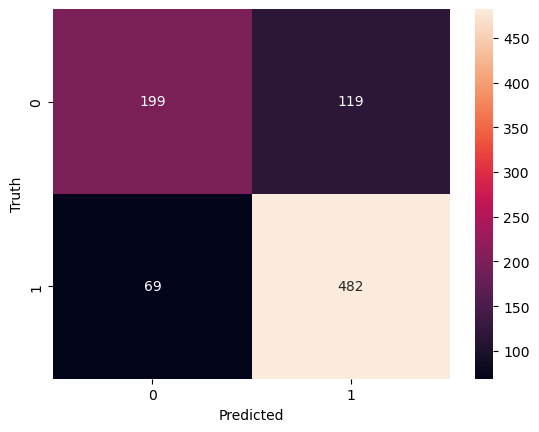

In [30]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [33]:
result_1 = (199 + 482) / (199 + 119 + 69 + 482)
result_1

0.7836593785960875

In [34]:
result_2=model.evaluate(X_test,y_test)

28/28 [==============================] - 2s 64ms/step - loss: 0.4540 - accuracy: 0.7837


# Conclusion

From both of the results, the accuracy of the model is around 78%. The BERT model is also used for model building but was in the end not chosen as it's accuracy is much lower at approximately 63%. Moreover, the BERT model is more computationally intensive as it took around 5s per step compared to ~450ms in the nnlm model. 